In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications import VGG19
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle
from keras.models import Model
#Dataset Loading and Preprocessing:
dataset = 'C:/Users/Asma/Downloads/Wheat Disease Dataset'
label_path = "lb.pickle"

LABELS = set(["Fusarium Head Blight", "Healthy Wheat", "Leaf Rust", "Tan Spot"])

imagePaths = list(paths.list_images(dataset))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    if label not in LABELS:
        continue

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)
#Label Encoding:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#Train-Test Split:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.25, stratify=labels, random_state=42)
#Data Augmentation:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()
#Mean Subtraction:
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
#Base Model Initialization:
headmodel = VGG19(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
#Adding Custom Layers:
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
# Define output layers for multi-task learning
output_fusion = Dense(1, activation="sigmoid", name="fusion_output")(model)
output_segmentation = Dense(len(lb.classes_), activation="softmax", name="segmentation_output")(model)

moodel = Model(inputs=headmodel.input, outputs=[output_fusion, output_segmentation])

for layer in headmodel.layers:
    layer.trainable = False

opt = Adam(lr=1e-3)
#Model Compilation:
moodel.compile(loss={"fusion_output": "binary_crossentropy", "segmentation_output": "categorical_crossentropy"},
               optimizer=opt,
               metrics={"fusion_output": "accuracy", "segmentation_output": "accuracy"})


In [ ]:
print("Shape of trainX:", trainX.shape)
print("Shape of trainY:", trainY.shape)



Shape of trainX: (696, 224, 224, 3)
Shape of trainY: (696, 3)


In [ ]:
# Define separate data generators for fusion output and segmentation output
train_generator = trainAug.flow(trainX, trainY, batch_size=16)
test_generator = valAug.flow(testX, testY, batch_size=16)

H = moodel.fit(
    train_generator,
    steps_per_epoch=len(trainX) // 16,
    validation_data=test_generator,
    validation_steps=len(testX) // 16,
    epochs=10)



Epoch 1/10



43/43 [==============================] - 448s 10s/step - loss: 3.1439 - fusion_output_loss: 1.8028 - segmentation_output_loss: 1.3411 - fusion_output_accuracy: 0.5578 - segmentation_output_accuracy: 0.7735 - val_loss: 1.9074 - val_fusion_output_loss: 1.0115 - val_segmentation_output_loss: 0.8959 - val_fusion_output_accuracy: 0.6220 - val_segmentation_output_accuracy: 0.8571
Epoch 2/10
43/43 [==============================] - 432s 10s/step - loss: 1.8170 - fusion_output_loss: 1.2369 - segmentation_output_loss: 0.5800 - fusion_output_accuracy: 0.5608 - segmentation_output_accuracy: 0.8794 - val_loss: 1.5425 - val_fusion_output_loss: 0.9561 - val_segmentation_output_loss: 0.5863 - val_fusion_output_accuracy: 0.6473 - val_segmentation_output_accuracy: 0.9018
Epoch 3/10
43/43 [==============================] - 429s 10s/step - loss: 1.4637 - fusion_output_loss: 0.9744 - segmentation_output_loss: 0.4893 - fusion_output_accuracy: 0.5770 - segmentation_output_accuracy: 0.8794 - val_loss: 1.4124

In [ ]:
#evaluates the model's performance on the test data and prints classification reports for both the fusion output and segmentation output.
predictions_fusion, predictions_segmentation = moodel.predict(testX, batch_size=16)
print("Fusion Output:")
print(classification_report(testY.argmax(axis=1),
                            predictions_fusion.argmax(axis=1), target_names=lb.classes_))
print("Segmentation Output:")
print(classification_report(testY.argmax(axis=1),
                            predictions_segmentation.argmax(axis=1), target_names=lb.classes_))


4/4 [==============================] - 87s 20s/step
Fusion Output:
                      precision    recall  f1-score   support

Fusarium Head Blight       0.34      1.00      0.51        80
       Healthy Wheat       0.00      0.00      0.00        86
           Leaf Rust       0.00      0.00      0.00        67

            accuracy                           0.34       233
           macro avg       0.11      0.33      0.17       233
        weighted avg       0.12      0.34      0.18       233

Segmentation Output:
                      precision    recall  f1-score   support

Fusarium Head Blight       0.97      0.76      0.85        80
       Healthy Wheat       0.82      0.97      0.89        86
           Leaf Rust       0.88      0.91      0.90        67

            accuracy                           0.88       233
           macro avg       0.89      0.88      0.88       233
        weighted avg       0.89      0.88      0.88       233



C:\Users\Asma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


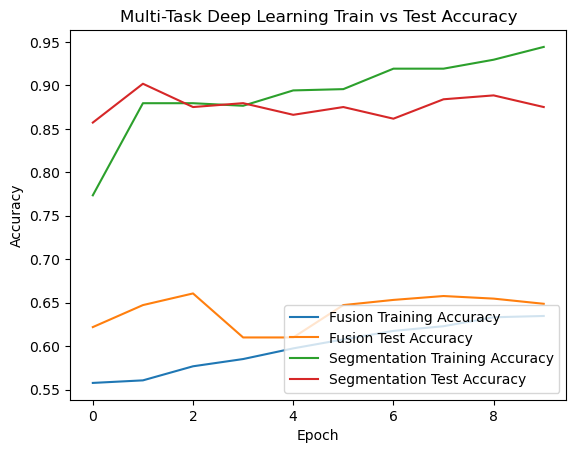

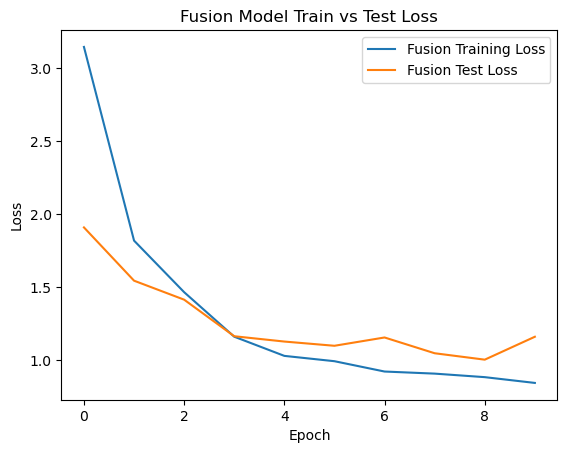

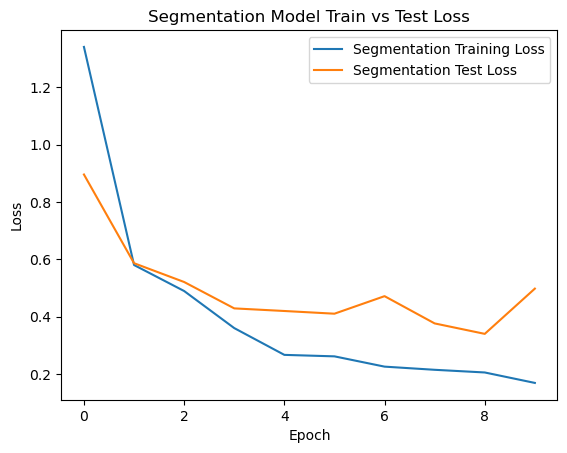

<Figure size 640x480 with 0 Axes>

In [ ]:
#providing insights into the training process and potential overfitting or underfitting issues.
N = 10
plt.plot(np.arange(0, N), H.history['fusion_output_accuracy'], label="Fusion Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_fusion_output_accuracy'], label="Fusion Test Accuracy")
plt.plot(np.arange(0, N), H.history['segmentation_output_accuracy'], label="Segmentation Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_segmentation_output_accuracy'], label="Segmentation Test Accuracy")
plt.title('Multi-Task Deep Learning Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig("accuracy_plot.png")

plt.plot(H.history['loss'], label="Fusion Training Loss")
plt.plot(H.history['val_loss'], label="Fusion Test Loss")
plt.title('Fusion Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig("fusion_loss_plot.png")

plt.plot(H.history['segmentation_output_loss'], label="Segmentation Training Loss")
plt.plot(H.history['val_segmentation_output_loss'], label="Segmentation Test Loss")
plt.title('Segmentation Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig("segmentation_loss_plot.png")

In [ ]:
# save the model to disk
moodel.save("fusion_segmentation_model.h5")

# save the label binarizer to disk
with open(label_path, "wb") as f:
    f.write(pickle.dumps(lb))

C:\Users\Asma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


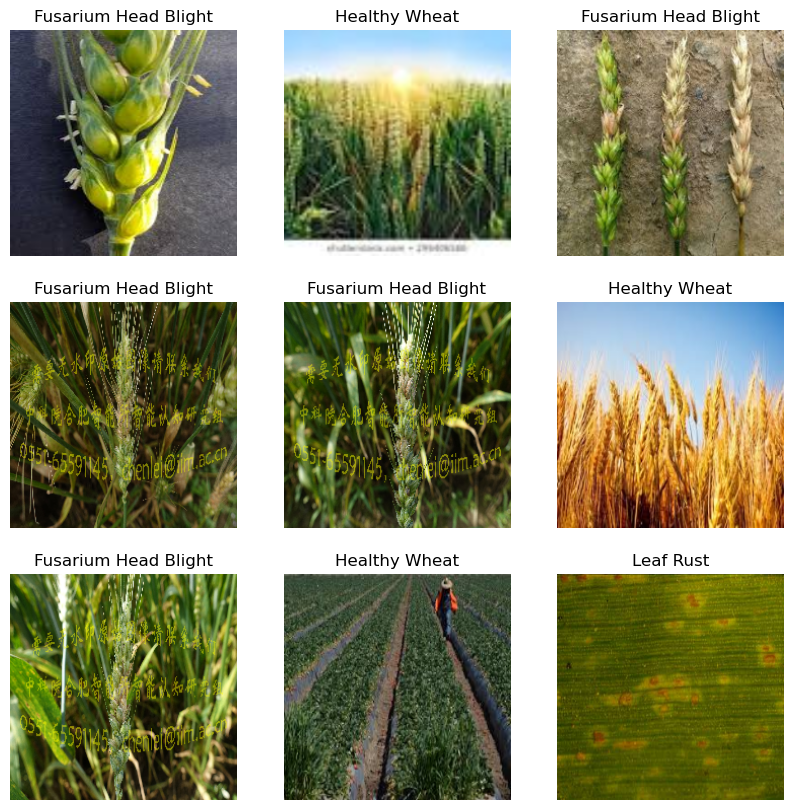

In [ ]:
import matplotlib.pyplot as plt

# Define a function to decode the label
def decode_label(label):
    if label[0] == 1:
        return "Fusarium Head Blight"
    elif label[1] == 1:
        return "Healthy Wheat"
    elif label[2] == 1:
        return "Leaf Rust"
    elif label[3] == 1:
        return "Tan Spot"
    else:
        return "Unknown"

# Plot sample images with labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Plotting 9 sample images
    plt.subplot(3, 3, i + 1)
    plt.imshow(trainX[i])  # Plot the image
    plt.title(decode_label(trainY[i]))  # Decode and plot the label
    plt.axis("off")

plt.show()